#Librerias

In [ ]:
!pip install opencv-python # instala la librería OpenCV para procesamiento de imágenes

In [ ]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [ ]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [ ]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Selección de métrica o indicador para evaluación de modelos

## **Existen los siguientes indicadores que pueden servir para el contexto de este análisis**

- **Precision:** Tasa de acierto en los positivos predichos (¿qué porcentaje de las imágenes clasificadas como cáncer de piel realmente lo eran?). Un valor alto indica que el modelo comete pocos falsos positivos, lo cual es importante para evitar alarmar o tratar innecesariamente a pacientes sanos.

- **Recall (Sensibilidad):** Tasa de detección de positivos (de todas las imágenes que realmente eran cáncer de piel, ¿cuántas fueron correctamente identificadas por el modelo?). Fundamental cuando se desea minimizar los falsos negativos, es decir, evitar pasar por alto un caso real de cáncer.

- **F1_Score:** Media armónica entre Precision y Recall. Es útil cuando se busca un equilibrio entre no perder casos positivos (Recall) y no clasificar en exceso como positivos (Precision). Ideal cuando hay desbalance entre clases, como en conjuntos con pocos casos de cáncer comparados con lesiones benignas.

- **Accuracy:** Porcentaje total de imágenes correctamente clasificadas (tanto benignas como malignas). Aunque es fácil de interpretar, puede ser **engañoso en problemas desbalanceados** como el cáncer de piel (por ejemplo, si solo el 5% son malignas, un modelo que siempre predice "benigno" tendría 95% de accuracy pero no detectaría ningún caso real de cáncer).

- **AUC (Área bajo la curva ROC):** Evalúa la capacidad del modelo para distinguir entre clases (lesiones malignas vs. benignas). Mide la tasa de verdaderos positivos frente a la de falsos positivos en todos los umbrales posibles. A mayor AUC, mejor es el modelo para **discriminar entre cáncer y no cáncer**, independientemente del umbral de decisión usado.

- **Especificidad (Specificity):** Proporción de negativos correctamente identificados (de todas las imágenes benignas, ¿cuántas fueron correctamente clasificadas como no cáncer?). Es el complemento del Recall. Útil cuando se desea reducir los falsos positivos, por ejemplo, para no derivar innecesariamente a muchos pacientes sanos a exámenes adicionales.

- **Log Loss (Pérdida Logarítmica):** Mide la incertidumbre del modelo en sus predicciones de probabilidad. Penaliza más los errores de clasificación con alta confianza. Útil para modelos probabilísticos que devuelven una probabilidad de malignidad, no solo una clase binaria.

- **Balanced Accuracy:** Promedio entre Sensibilidad y Especificidad. Útil cuando las clases están desbalanceadas, ya que equilibra la atención entre detectar bien los casos de cáncer y evitar falsas alarmas.



## **Análisis del problema y eleccion de métrica más adecuada**
En este caso, se clasifican las imágenes de lesiones en la piel para identificar casos de cáncer de piel. Nos interesa especialmente detectar correctamente los casos positivos (cáncer), ya que omitir uno de estos casos (falsos negativos), podría tener consecuencias muy graves para la salud del paciente.

Por eso, el **Recall** es crítico, ya que queremos minimizar el número de cánceres no detectados. Sin embargo, enfocarnos únicamente en Recall puede hacer que el modelo clasifique excesivamente como "cáncer" a algunos pacientes, aumentando los falsos positivos (lo cual en la vida real implicaria biopsias innecesarias, papeleos inncesarios, estrés para el paciente, etc.)

Para equilibrar la capacidad de detección de cáncer con la tasa de falsos positivos, el mejor indicador en este contexto es el **AUC**. Este mide la capacidad del modelo para diferenciar entre lesiones benignas y malignas, a través de todos los posibles umbrales de clasificación. Un alto AUC significa que el modelo puede distinguir bien entre ambas clases, maximizando de esta forma la detección de cáncer, sin comprometer demasiado la clasificación de los casos benignos.

En conclusión, se elige el AUC como indicador principal, ya que mide la capacidad del modelo para diferenciar entre cáncer y no cáncer, incluso con clases desbalanceadas. También se considerará el Recall como indicador secundario, para asegurar que los casos de cáncer sean detectados correctamente y evaluar en los modelos que sea posible si ambos indicadores pueden ofrecer buenos resultados simultáneamente.


# Carga de datos procesados

array([[[220, 134, 142],
        [218, 131, 147],
        [234, 147, 164],
        ...,
        [232, 153, 167],
        [227, 156, 169],
        [228, 154, 176]],

       [[212, 129, 138],
        [219, 135, 150],
        [231, 147, 163],
        ...,
        [229, 151, 164],
        [227, 156, 171],
        [228, 155, 175]],

       [[208, 127, 135],
        [219, 136, 153],
        [229, 146, 162],
        ...,
        [227, 150, 162],
        [227, 154, 170],
        [230, 157, 176]],

       ...,

       [[211, 137, 150],
        [209, 135, 148],
        [212, 138, 151],
        ...,
        [214, 149, 158],
        [213, 150, 159],
        [206, 144, 153]],

       [[210, 138, 149],
        [210, 139, 150],
        [212, 140, 152],
        ...,
        [215, 149, 159],
        [211, 148, 157],
        [207, 146, 154]],

       [[212, 141, 152],
        [211, 141, 151],
        [213, 141, 152],
        ...,
        [214, 147, 158],
        [211, 148, 157],
        [208, 147, 155]]], dtype=uint8)
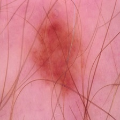

In [ ]:
# Cargar los conjuntos (arrays) de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [ ]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [ ]:
#Visualizar forma de las imagenes para luego convertir a 1D
print(x_train.shape)
print(x_test.shape)

(2317, 120, 120, 3)
(580, 120, 120, 3)


In [ ]:
 # Convertir imágenes en vectores 1D de tamaño 43200
x_train2=x_train.reshape(2317,43200) # para convertilos en (120,120,3)
x_test2=x_test.reshape(580, 43200)

print(x_train2.shape) # Mostrar forma del arreglo de entrenamiento
print(x_test2.shape) # Mostrar forma del arreglo de prueba

x_train2[1]

(2317, 43200)
(580, 43200)


array([0.96862745, 0.6666667 , 0.69803923, ..., 0.9137255 , 0.6392157 ,
       0.6392157 ], dtype=float32)

# Entrenamiento y evaluación de modelos tradicionales en el análisis del cancer de piel

## Modelo 1: Bosques Aleatorios

In [ ]:
rf = RandomForestClassifier() # Modelo de bosques aleatorios
rf.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = rf.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
auc_rf = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para bosques aleatorios
recall_rf = metrics.recall_score(y_test, pred_test) # Calcular recall para bosques aleatorios

# Imprimir metricas metricas
print("Random Forest - AUC:", auc_rf)
print("Random Forest - Recall:", recall_rf)

Random Forest - AUC: 0.8382324618421686
Random Forest - Recall: 0.8565891472868217


## Modelo 2: Árbol de Decisión

In [ ]:
clf_dt = tree.DecisionTreeClassifier() # Modelo de arbol de decision
clf_dt.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = clf_dt.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

In [ ]:
auc_dt = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para arbol de decision
recall_dt = metrics.recall_score(y_test, pred_test) # Calcular recall para arbol de decision

# Imprimir metricas metricas
print("Decision Tree - AUC:", auc_dt)
print("Decision Tree - Recall:", recall_dt)

Decision Tree - AUC: 0.7304636718185757
Decision Tree - Recall: 0.6627906976744186


## Modelo 3: K-Vecinos más cercanos

In [ ]:
knn = KNeighborsClassifier() # Modelo de vecinos mas cercanos
knn.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = knn.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
auc_knn = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para vecinos mas cercanos
recall_knn = metrics.recall_score(y_test, pred_test) # Calcular recall para vecinos mas cercanos

# Imprimir metricas metricas
print("KNN - AUC:", auc_knn )
print("KNN - Recall:", recall_knn)

KNN - AUC: 0.7297655159131399
KNN - Recall: 0.562015503875969


## Modelo 4: Regresión logística

In [ ]:
logreg = LogisticRegression(max_iter=500) # modelo de regresión logística con 500 iteraciones
logreg.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = logreg.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
auc_lr = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para regresión logística
recall_lr = metrics.recall_score(y_test, pred_test) #Calcular recall para regresión logística

# Imprimir metricas metricas
print("Logistic Regression - AUC:", auc_lr)
print("Logistic Regression - Recall:", recall_lr)

Logistic Regression - AUC: 0.7692715104241898
Logistic Regression - Recall: 0.6782945736434108


## Modelo 5: Red neuronal simple

In [ ]:
 # Crear modelo secuencial (capas apiladas)
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]), #Aplanar entrada
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa con 128 neuronas y ReLU
    tf.keras.layers.Dense(64, activation='relu'), # Capa densa con 64 neuronas y ReLU
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida (1 neurona), activación sigmoide para clasificación binaria
])

checkpoint = ModelCheckpoint(
    filepath='Salidas/best_model_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Optimizador y funcion de perdida para el modelo
fc_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Recall', 'Precision'] #Metricas a evaluar
)

# entrenar el modelo con validacion
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - AUC: 0.5147 - Precision: 0.4604 - Recall: 0.4748 - accuracy: 0.5179 - loss: 5.3300
Epoch 1: val_AUC improved from -inf to 0.71425, saving model to Salidas/best_model_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - AUC: 0.5170 - Precision: 0.4632 - Recall: 0.4755 - accuracy: 0.5202 - loss: 5.2335 - val_AUC: 0.7142 - val_Precision: 0.4448 - val_Recall: 1.0000 - val_accuracy: 0.4448 - val_loss: 1.7002
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - AUC: 0.6318 - Precision: 0.5459 - Recall: 0.5906 - accuracy: 0.5883 - loss: 1.2870
Epoch 2: val_AUC improved from 0.71425 to 0.83347, saving model to Salidas/best_model_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - AUC: 0.6312 - Precision: 0.5453 - Recall: 0.5881 - accuracy: 0.5879 - loss: 1.2881 - val_AUC: 0.8335 - val_Precision: 0.7655 - val_Recall: 0.4302 - val_accuracy: 0.6879 - val_loss: 0.5788
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - AUC: 0.7738 - Precisi

In [ ]:
#Metricas de evaluacion de la red neuronal simple
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)

# Mostrar metricas
print("\n### Resultados Red Neuronal ###")
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)

19/19 - 0s - 16ms/step - AUC: 0.8701 - Precision: 0.8571 - Recall: 0.3488 - accuracy: 0.6845 - loss: 0.6443

### Resultados Red Neuronal ###
Test Accuracy: 0.684482753276825
Test AUC: 0.8700828552246094
Test Recall: 0.3488371968269348
Test Precision: 0.8571428656578064


In [ ]:
best_auc=tf.keras.models.load_model('Salidas/best_model_auc.keras')
test_best_loss, test_best_acc, test_best_auc, test_best_recall, test_best_precision = best_auc.evaluate(x_test, y_test, verbose=2)
print("\n### Resultados Red Neuronal maximizando el AUC ###")
print("Test Accuracy:", test_best_acc)
print("Test AUC:", test_best_auc)
print("Test Recall:", test_best_recall)
print("Test Precision:", test_best_precision)

19/19 - 3s - 132ms/step - AUC: 0.8701 - Precision: 0.8571 - Recall: 0.3488 - accuracy: 0.6845 - loss: 0.6443

### Resultados Red Neuronal maximizando el AUC ###
Test Accuracy: 0.684482753276825
Test AUC: 0.8700828552246094
Test Recall: 0.3488371968269348
Test Precision: 0.8571428656578064


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       322
           1       0.86      0.35      0.50       258

    accuracy                           0.68       580
   macro avg       0.75      0.65      0.63       580
weighted avg       0.74      0.68      0.65       580



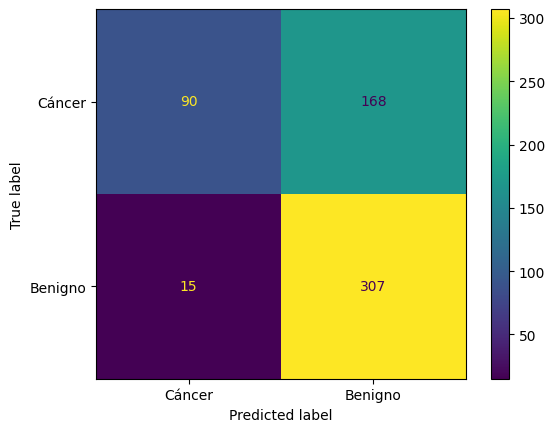

In [ ]:
pred_test = (fc_model.predict(x_test) > 0.50).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'Benigno']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Resumen de indicadores

In [ ]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["Random Forest", "Árbol de Decisión", "KNN", "Regresión Logística", "Red Neuronal"], # Nombres de los modelos
    "AUC": [auc_rf, auc_dt, auc_knn, auc_lr, test_best_auc], # metricas auc de todos los modelos
    "Recall": [recall_rf, recall_dt, recall_knn, recall_lr, test_best_recall] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═════════════════════╤══════════╤══════════╕
│ Modelo              │      AUC │   Recall │
╞═════════════════════╪══════════╪══════════╡
│ Red Neuronal        │ 0.870083 │ 0.348837 │
├─────────────────────┼──────────┼──────────┤
│ Random Forest       │ 0.838232 │ 0.856589 │
├─────────────────────┼──────────┼──────────┤
│ Regresión Logística │ 0.769272 │ 0.678295 │
├─────────────────────┼──────────┼──────────┤
│ Árbol de Decisión   │ 0.730464 │ 0.662791 │
├─────────────────────┼──────────┼──────────┤
│ KNN                 │ 0.729766 │ 0.562016 │
╘═════════════════════╧══════════╧══════════╛


En la tabla se presentan los resultados de distintos modelos de clasificación evaluados mediante dos métricas clave: AUC (Área Bajo la Curva ROC) y Recall. El AUC refleja la capacidad del modelo para distinguir entre clases, siendo valores cercanos a 1 indicativos de un buen desempeño general. En este caso, el modelo con mayor AUC fue la Red Neuronal (0.8701), lo que indica una alta capacidad discriminativa. Le sigue el Random Forest (0.8382), también con un rendimiento sobresaliente en esta métrica.

Por otro lado, el Recall mide la proporción de casos positivos correctamente identificados, lo cual es crucial en contextos como la detección de cáncer, donde no pasar por alto casos verdaderos es prioritario. Aquí, el Random Forest se destaca como el mejor modelo con un Recall de 0.8566, seguido por la Regresión Logística (0.6783) y el Árbol de Decisión (0.6628). Aunque la Red Neuronal obtuvo el mayor AUC, su Recall fue el más bajo (0.3488), lo que sugiere que no identifica con eficacia una alta proporción de los casos positivos.

Modelos como KNN (AUC: 0.7298, Recall: 0.5620) y el Árbol de Decisión presentan un desempeño intermedio, mostrando que existe una compensación entre ambas métricas. En conjunto, los resultados reflejan la importancia de definir claramente el objetivo del modelo: si se busca maximizar la detección de casos positivos (Recall), o lograr un buen balance general entre clases (AUC). Esta decisión resulta especialmente crítica en aplicaciones médicas, donde una alta sensibilidad puede marcar la diferencia en la detección temprana de enfermedades como el cáncer.